In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
from tcre.env import *
from tcre.supervision import *
from tcre.modeling import utils
from tcre.modeling import features
import plotnine as pn
%matplotlib inline
%run ../../../src/tcre/logging.py
session = SnorkelSession()
classes = get_candidate_classes()

In [187]:
output_dir = osp.join(RESULTS_DATA_DIR, 'simulations', 'run1')
output_dir

'/lab/data/results/simulations/run1'

### Simulation Development

Add features/functions necessary to create near-deterministic relationships between features and labels

In [2]:
from snorkel.models import Candidate, GoldLabel
candidate_class = classes.inducing_cytokine
cands = session.query(candidate_class.subclass)\
    .filter(candidate_class.subclass.split == SPLIT_DEV).all()
len(cands)

673

In [234]:
import imp
imp.reload(features)

<module 'tcre.modeling.features' from '/lab/repos/t-cell-relation-extraction/src/tcre/modeling/features.py'>

In [235]:
pd.set_option('display.max_colwidth', 250)

# Secondary + swaps
markers = {
    'primary': {ENT_TYP_CT_L: ['{#', '#}'], ENT_TYP_CK_L: ['{%', '%}']},
    'secondary': {ENT_TYP_CT_L: ['|#', '#|'], ENT_TYP_CK_L: ['|%', '%|']}
}
swaps = {
    'primary': {ENT_TYP_CT_L: '{CL}', ENT_TYP_CK_L: '{CK}'},
    'secondary': {ENT_TYP_CT_L: '|CL|', ENT_TYP_CK_L: '|CK|'}
}
predicate = lambda e: e['type'] in candidate_class.entity_types

# Secondary + no swaps
swaps = None

# Primary + swaps
# markers = {
#     'primary': {ENT_TYP_CT_L: ['{#', '#}'], ENT_TYP_CK_L: ['{%', '%}']},
#     'secondary': None
# }
# swaps = {
#     'primary': {ENT_TYP_CT_L: '{CL}', ENT_TYP_CK_L: '{CK}'},
#     'secondary': None
# }
# predicate = lambda e: e['is_candidate'] and e['type'] in candidate_class.entity_types

print(sorted(features.get_specials(markers, swaps)))

['#|', '#}', '%|', '%}', '{#', '{%', '|#', '|%']


In [236]:
df = features.get_record_features(
    features.candidates_to_records(cands, entity_predicate=predicate), markers=markers, swaps=swaps, 
    subtokenizer=lambda t: t.split(), lower=False, assert_unique=False
).rename(columns={'tokens': 'text'})
df.head()


100%|██████████| 673/673 [00:01<00:00, 442.41it/s]

,id,label,e0_dist,e0_text,e1_dist,e1_text,tags,text
0,30167,1.0,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]",IL-12,"[-26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]",TH1,"[O, E:primary:cytokine, O, O, O, O, O, E:secondary:cytokine, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, E:primary:immune_cell_type, O, O, O]","[{%, IL-12, %}, induces, not, only, |%, Ifng, %|, expression1, but, also, T, -, bet, ,, which, promotes, the, survival, and, proliferation, of, differentiating, {#, TH1, #}, cells, .]"
1,30168,0.0,"[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]",Ifng,"[-26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]",TH1,"[O, E:secondary:cytokine, O, O, O, O, O, E:primary:cytokine, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, E:primary:immune_cell_type, O, O, O]","[|%, IL-12, %|, induces, not, only, {%, Ifng, %}, expression1, but, also, T, -, bet, ,, which, promotes, the, survival, and, proliferation, of, differentiating, {#, TH1, #}, cells, .]"
2,30169,1.0,"[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]",TGFβ,"[-25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]",Th17,"[O, O, O, O, E:primary:cytokine, O, O, O, O, E:secondary:cytokine, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, E:primary:immune_cell_type, O, O, O, O, O, O]","[In, mice, ,, {%, TGFβ, %}, together, with, |%, IL6, %|, can, activate, antigen, -, responsive, naïve, CD4, +, T, cells, to, develop, into, {#, Th17, #}, cells, [, 39, ], .]"
3,30170,1.0,"[-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]",IL6,"[-25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]",Th17,"[O, O, O, O, E:secondary:cytokine, O, O, O, O, E:primary:cytokine, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, E:primary:immune_cell_type, O, O, O, O, O, O]","[In, mice, ,, |%, TGFβ, %|, together, with, {%, IL6, %}, can, activate, antigen, -, responsive, naïve, CD4, +, T, cells, to, develop, into, {#, Th17, #}, cells, [, 39, ], .]"
4,30171,0.0,"[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]",IL-12,"[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]",Th1,"[O, O, O, O, O, O, O, O, O, O, E:primary:immune_cell_type, O, O, O, O, E:primary:cytokine, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, E:secondary:cytokine, O, O, O, O, O, E:secondary:cytokine, O, O, O, O, O, O, O]","[Several, findings, suggest, that, during, the, initiation, of, a, {#, Th1, #}, response, ,, {%, IL-12, %}, is, produced, particularly, by, macrophages, in, response, to, certain, microbial, antigens, ,, while, NK, cells, are, the, main, source, ..."


In [268]:
from tcre.modeling import simulation
import imp
imp.reload(simulation)

<module 'tcre.modeling.simulation' from '/lab/repos/t-cell-relation-extraction/src/tcre/modeling/simulation.py'>

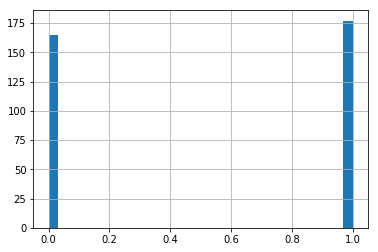

In [270]:
#labels = simulation.get_simulated_labels(df, strategy='position-based')
#labels = simulation.get_simulated_labels(df, strategy='secondary-marking')
labels = simulation.get_simulated_labels(df, strategy='random')
pd.Series(labels).hist(bins=32)

## Simulation Modeling

For each of the above scenarios, run a model with a control configuration to prove that the pattern can be recapitulated by the model.

#### Splits

These will apply to all simulations:

In [271]:
splits_file = osp.join(output_dir, 'splits', 'splits.json')

def write_splits(cands, splits_file):
    if not osp.exists(osp.dirname(splits_file)):
        os.makedirs(osp.dirname(splits_file))
        
    split_map = {0: 'train', 1: 'val', 2: 'test'}
    splits = pd.DataFrame([dict(id=c.id, split=split_map[i % 3]) for i, c in enumerate(cands)]).groupby('split')['id'].unique()
    print('Split sizes:', splits.apply(len).to_dict())
    splits.to_json(splits_file, orient='index')

In [272]:
def get_cands(limit=2500*3):
    # Pull arbitrary list of candidates with max length (they will be resplit later)
    return session.query(candidate_class.subclass)\
        .filter(candidate_class.subclass.split.in_([SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_TRAIN])).limit(limit).all()

all_cands = get_cands()
write_splits(all_cands, splits_file)
splits_file

Split sizes: {'test': 2500, 'train': 2500, 'val': 2500}


'/lab/data/results/simulations/run1/splits/splits.json'

#### Configuration

In [273]:
from tcre.exec.v1 import cli_client
imp.reload(cli_client)

<module 'tcre.exec.v1.cli_client' from '/lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli_client.py'>

In [274]:
client = cli_client.get_default_client()
client.exceptions

['log_level',
 'seed',
 'vocab_limit',
 'use_lower',
 'save_keys',
 'log_iter_interval',
 'log_epoch_interval',
 'balance',
 'batch_size',
 'simulation_strategy',
 'swap_list']

In [275]:
def get_args(splits_file, output_dir, **kwargs):
    cli_args = dict(
        relation_class=candidate_class.field,
        output_dir=output_dir,
        batch_size=64,
        device='cuda:1'
    )
    train_args = dict(
        splits_file=splits_file,
        marker_list='doub_01',
        use_secondary=True,
        use_swaps=True,
        use_lower=False,
        use_positions=True,
        use_checkpoints=False,
        wrd_embedding_type='w2v_frozen',
        model_size='XL',
        bidirectional=False,
        cell_type='LSTM',
        learning_rate=.01,
        weight_decay=0,
        dropout=0,
        vocab_limit=50000,
        balance=0,
        log_iter_interval=50,
        log_epoch_interval=5
    )
    train_args.update(kwargs)
    return dict(cli=cli_args, train=train_args)

In [282]:
simulations = {
#     'position-features': {
#         'target': {'model_size': 'SIM1', 'use_positions': True, 'simulation_strategy': 'position-based'},
#         'control': {'model_size': 'SIM1', 'use_positions': False, 'simulation_strategy': 'position-based'},
#         'random': {'model_size': 'SIM1', 'use_positions': True, 'simulation_strategy': 'random'}
#     },
    'secondary-marking': {
        # Compare models with primary/secondary entity markers that can or cannot be disambiguated
        'target': {'model_size': 'XXXL', 'use_positions': False, 'simulation_strategy': 'secondary-marking', 'marker_list': 'doub_01', 'swap_list': 'dflt_01'},
        'control': {'model_size': 'XXXL', 'use_positions': False, 'simulation_strategy': 'secondary-marking', 'marker_list': 'siml_01', 'swap_list': 'siml_01'},
        'random': {'model_size': 'XXXL', 'use_positions': False, 'simulation_strategy': 'random'},
        'nospec': {'model_size': 'XXXL', 'use_positions': False, 'simulation_strategy': 'secondary-marking', 'marker_list': 'doub_01', 'swap_list': 'dflt_01'},
    }
}

#### Execution

In [ ]:
CMD_FORMAT = "{cmd} > {log_file} 2>&1"

for name, config in simulations.items():
    log_dir = osp.join(output_dir, 'simulations', name, 'logs')
    if not osp.exists(log_dir):
        os.makedirs(log_dir)
    for typ, overrides in config.items():
        assert 'simulation_strategy' in overrides
        model_dir = osp.join(output_dir, 'simulations', name, typ)
        log_file = osp.join(log_dir, f'log_{typ}.txt')
        args = get_args(splits_file, model_dir, **overrides)
        cmd = CMD_FORMAT.format(cmd=client.cmd(**args), log_file=log_file)
        hr = "-"*80
        print(f'{hr}\nRunning simulation {name}:{typ}; args = \n{args}\ncmd = {cmd}')
        client.execute(cmd)

--------------------------------------------------------------------------------
Running simulation secondary-marking:nospec; args = 
{'cli': {'relation_class': 'inducing_cytokine', 'output_dir': '/lab/data/results/simulations/run1/simulations/secondary-marking/nospec', 'batch_size': 64, 'device': 'cuda:1'}, 'train': {'splits_file': '/lab/data/results/simulations/run1/splits/splits.json', 'marker_list': 'doub_01', 'use_secondary': True, 'use_swaps': True, 'use_lower': False, 'use_positions': False, 'use_checkpoints': False, 'wrd_embedding_type': 'w2v_frozen', 'model_size': 'XXXL', 'bidirectional': False, 'cell_type': 'LSTM', 'learning_rate': 0.01, 'weight_decay': 0, 'dropout': 0, 'vocab_limit': 50000, 'balance': 0, 'log_iter_interval': 50, 'log_epoch_interval': 5, 'simulation_strategy': 'secondary-marking', 'swap_list': 'dflt_01'}}
cmd = python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=inducing_cytokine --output-dir=/lab/data/results/simulations/run

## Analysis

In [278]:
df = pd.concat([
    pd.read_json(osp.join(output_dir, 'simulations', name, grp, 'history.json')).assign(sim=name, grp=grp)
    for name, config in simulations.items()
    for grp in config
])
df.head()

,accuracy,ct,epoch,f1,loss,lr,precision,recall,type,sim,grp
0,0.7384,2500,1,0.785995,0.523300,0.01,0.959265,0.665743,training,secondary-marking,target
1,0.7296,2500,1,0.779085,0.532606,0.01,0.934902,0.667787,test,secondary-marking,target
2,0.7388,2500,1,0.785409,0.528925,0.01,0.944664,0.672103,validation,secondary-marking,target
3,0.7576,2500,2,0.807129,0.517832,0.01,0.947683,0.702882,training,secondary-marking,target
4,0.7428,2500,2,0.793844,0.528840,0.01,0.928036,0.693557,test,secondary-marking,target


In [279]:
df_lng = df.set_index(['sim', 'grp', 'epoch', 'type'])[['f1', 'loss']].rename_axis('metric', axis=1).stack().rename('value').reset_index()
df_lng.head()

,sim,grp,epoch,type,metric,value
0,secondary-marking,target,1,training,f1,0.785995
1,secondary-marking,target,1,training,loss,0.523300
2,secondary-marking,target,1,test,f1,0.779085
3,secondary-marking,target,1,test,loss,0.532606
4,secondary-marking,target,1,validation,f1,0.785409


In [280]:
def plot_metrics(df, sim):    
    return (
        pn.ggplot(
            df[df['sim'] == sim],
            pn.aes(x='epoch', y='value', color='type')
        ) + 
        pn.geom_line() + 
        pn.facet_grid('metric ~ grp', scales='free') + 
        pn.labs(title=sim) + 
        pn.theme_bw() + 
        pn.theme(figure_size=(12, 4))
    )

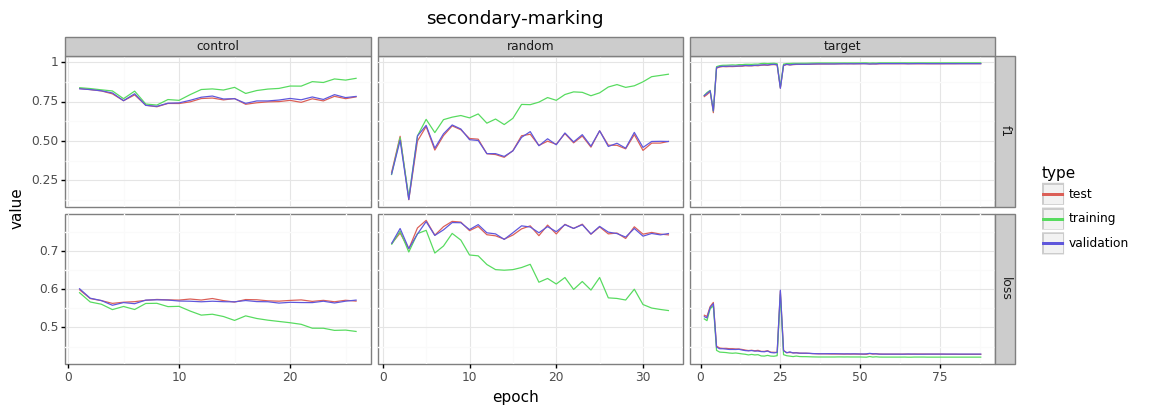

<ggplot: (-9223363248885291278)>

In [281]:
plot_metrics(df_lng, 'secondary-marking')

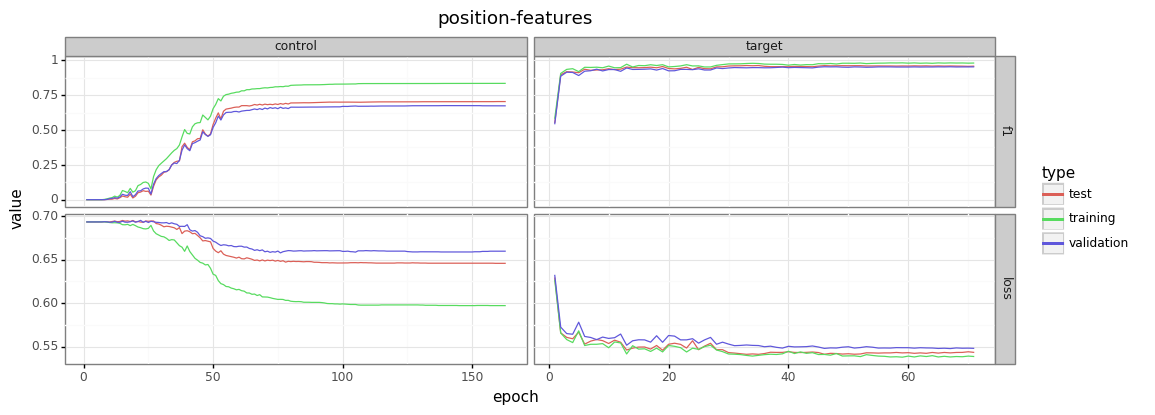

<ggplot: (-9223363248884186357)>

In [228]:
plot_metrics(df_lng, 'position-features')